In [4]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " I Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.8 GB  I Proc size: 143.6 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [5]:
!pip install torch torchvision tensorboardX

In [0]:
# from google.colab import files
# uploaded = files.upload()

In [7]:
!ls -lh
!du -hd1

total 55M
drwxr-xr-x 2 1000 users 4.0K Oct 14 18:55  data
drwxr-xr-x 2 1000 users 4.0K Oct 14 18:54  models
drwxr-xr-x 7 1000 users 4.0K Oct 14 18:53  runs
-rw-r--r-- 1 root root  1.4M Oct 14 19:21 'skipgramstate.tar (1).gz'
-rw-r--r-- 1 root root   54M Oct 14 18:55  skipgramstate.tar.gz
76K	./.config
166M	./data
19M	./runs
7.2M	./models
246M	.


In [0]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter

import pickle
import os
import random
from collections import defaultdict
import itertools
from timeit import default_timer as timer

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [9]:
!tar -xzvf skipgramstate.tar.gz

data/
data/acid_properties.csv
data/family_classification_metadata.tab
data/all_acid_dicts.pickle
data/nice_embed_tsne.csv
data/family_classification_sequences.tab
runs/
runs/Oct14_18-51-39_ca967056da89/
runs/Oct14_18-51-39_ca967056da89/events.out.tfevents.1539543099.ca967056da89
runs/Oct14_18-53-59_ca967056da89/
runs/Oct14_18-53-59_ca967056da89/events.out.tfevents.1539543239.ca967056da89
runs/Oct14_18-53-59_ca967056da89/projector_config.pbtxt
runs/Oct14_18-53-59_ca967056da89/00000/
runs/Oct14_18-53-59_ca967056da89/00000/default/
runs/Oct14_18-53-59_ca967056da89/00000/default/tensors.tsv
runs/Oct14_18-52-00_ca967056da89/
runs/Oct14_18-52-00_ca967056da89/events.out.tfevents.1539543120.ca967056da89
runs/Oct14_18-50-40_ca967056da89/
runs/Oct14_18-50-40_ca967056da89/events.out.tfevents.1539543040.ca967056da89
runs/Oct14_18-50-54_ca967056da89/
runs/Oct14_18-50-54_ca967056da89/events.out.tfevents.1539543054.ca967056da89
models/
models/model_2000.pth


In [10]:
seq_df = pd.read_table('data/family_classification_sequences.tab')
seq_df.head()

,Sequences
0,MAFSAEDVLKEYDRRRRMEALLLSLYYPNDRKLLDYKEWSPPRVQV...
1,MSIIGATRLQNDKSDTYSAGPCYAGGCSAFTPRGTCGKDWDLGEQT...
2,MQNPLPEVMSPEHDKRTTTPMSKEANKFIRELDKKPGDLAVVSDFV...
3,MDSLNEVCYEQIKGTFYKGLFGDFPLIVDKKTGCFNATKLCVLGGK...
4,MEAKNITIDNTTYNFFKFYNINQPLTNLKYLNSERLCFSNAVMGKI...


In [0]:
counter = itertools.count()
cod2id = defaultdict(lambda: next(counter))

def make_codones(sseq):
    crop = len(sseq) % 3
    cropped_seq = sseq[:-crop] if crop > 0 else sseq

    return [cod2id[cropped_seq[i:i+3]] for i in range(0, len(cropped_seq), 3)]

def seq_to3(seq):
    splittings = [make_codones(seq[i:]) for i in range(3)]
    return splittings

def create_all_codones(df):
    codones = []

    for i in range(df.shape[0]):
        row = df.iloc[i, :][0]
        codones.extend(seq_to3(row))
    return codones

In [0]:
def read_or_create(read_path, producer):
    if os.path.isfile(read_path):
        print('reading', read_path)
        with open(read_path, 'rb') as fp:
            return pickle.load(fp)
    result = producer()
    print('saving', read_path)
    with open(read_path, 'wb') as fp:
        pickle.dump(result, fp)
    return result

In [13]:
all_codones = read_or_create(read_path='data/all_codones.pickle',
                             producer= lambda: create_all_codones(seq_df))

saving data/all_codones.pickle


In [14]:
!ls -lh data

total 560M
-rw-r--r-- 1 1000 users  563 Aug  2  2017 acid_properties.csv
-rw-r--r-- 1 1000 users 1.4M Oct 14 17:54 all_acid_dicts.pickle
-rw-r--r-- 1 root root  394M Oct 14 19:24 all_codones.pickle
-rw-r--r-- 1 1000 users  32M Aug  3  2017 family_classification_metadata.tab
-rw-r--r-- 1 1000 users 133M Aug  3  2017 family_classification_sequences.tab
-rw-r--r-- 1 1000 users 398K Aug  2  2017 nice_embed_tsne.csv


In [0]:
######################

In [0]:
def generate_sample(index_words_list, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for index_words in index_words_list:
        for index, center in enumerate(index_words):
            context = random.randint(1, context_window_size)
            # get a random target before the center word
            for target in index_words[max(0, index - context): index]:
                yield center, target
            # get a random target after the center wrod
            for target in index_words[index + 1: index + context + 1]:
                yield center, target

def get_batch(iterator, batch_size):
    """ Group a numerical stream into batches and yield them as Numpy arrays. """
    while True:
        center_batch = torch.zeros(batch_size, dtype=torch.long)
        target_batch = torch.zeros(batch_size, dtype=torch.long)
        for index in range(batch_size):
            center_batch[index], target_batch[index] = next(iterator)
        yield center_batch.cuda(), target_batch.cuda()

def flatten(x):
    return [item for sublist in x for item in sublist]

def count_codones(all_codones):
    return np.bincount(flatten(all_codones))

def process_data(all_codones, batch_size, skip_window):
    single_gen = generate_sample(all_codones, context_window_size=skip_window)
    batch_gen = get_batch(single_gen, batch_size=batch_size)
    return batch_gen

In [0]:
BATCH_SIZE = 128
SKIP_WINDOW = 12  # the context window

In [0]:
######################

In [0]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embed_size):
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.embed_aux = nn.Embedding(vocab_size, embed_size)
        
    def forward(self, in_words, out_words, sampled_words):
        in_words = self.embed(in_words)
        out_words = self.embed_aux(out_words)
        sampled_words = self.embed_aux(sampled_words)
        
        # batch dot product; torch.bmm is said to be slower for this task
        losses = F.logsigmoid((in_words * out_words).sum(dim=1))
        sampled_losses = F.logsigmoid(torch.bmm(-sampled_words,
                                                in_words.unsqueeze(-1))
                                      .squeeze(dim=2)).sum(dim=1)
        
        return -(losses + sampled_losses).mean()

In [0]:
######################

In [0]:
p = np.array(count_codones(all_codones))
p = p**0.75
p /= p.sum()

def neg_sample(size):
    return np.random.choice(len(cod2id), size=size, p=p)

In [0]:
EMBED_SIZE = 100  # dimension of the word embedding vectors
NUM_SAMPLED = 5  # Number of negative examples to sample.
LEARNING_RATE = .05
N_STEPS = 1000000
N_DEBUG_OUTPUT_STEPS = N_STEPS / 5000
START_STEP = 200000
random.seed(117)  # to reproduce batches
batch_gen = process_data(all_codones, BATCH_SIZE, SKIP_WINDOW)

In [0]:
def train(model, optimizer, batch_gen):
    start_time = timer()
    writer = SummaryWriter()
    for t, batch in itertools.islice(enumerate(batch_gen),
                                               START_STEP,
                                               START_STEP + N_STEPS):
        in_words, out_words = batch
        sampled_words = in_words.new_tensor(
            neg_sample((*in_words.size(), NUM_SAMPLED)))
        
        optimizer.zero_grad()
        loss = model(in_words, out_words, sampled_words)
        loss.backward()
        optimizer.step()
        
        writer.add_scalar('Loss', -loss, t)
        if (t + 1) % N_DEBUG_OUTPUT_STEPS == 0:
            print('Step {}, current loss is {:.3f}, time spent: {:.3f} seconds'
                  .format(t + 1, -loss.item(), timer() - start_time))
    writer.add_text('finish_time',
                    ('Learning finished in {:.3f} seconds from step {}' + 
                     ' to step {}')
                    .format(timer() - start_time, START_STEP, N_STEPS))
    writer.add_embedding(model.embed.weight)
    
    writer.close()

In [62]:
model = SkipGram(len(cod2id), EMBED_SIZE)
if os.path.exists('models/model_{}.pth'.format(START_STEP)):
    print('Loading model from', 'models/model_{}.pth'.format(START_STEP))
    model.load_state_dict(torch.load('models/model_{}.pth'.format(START_STEP)))
model = model.cuda()
train(model, torch.optim.SGD(model.parameters(), lr=LEARNING_RATE), batch_gen)

Loading model from models/model_200000.pth
Step 200200, current loss is -8.844, time spent: 529.945 seconds
Step 200400, current loss is -8.247, time spent: 531.211 seconds
Step 200600, current loss is -8.692, time spent: 532.467 seconds
Step 200800, current loss is -6.521, time spent: 533.715 seconds
Step 201000, current loss is -8.156, time spent: 534.976 seconds
Step 201200, current loss is -8.440, time spent: 536.230 seconds
Step 201400, current loss is -10.223, time spent: 537.490 seconds
Step 201600, current loss is -7.807, time spent: 538.750 seconds
Step 201800, current loss is -6.630, time spent: 540.009 seconds
Step 202000, current loss is -8.088, time spent: 541.273 seconds
Step 202200, current loss is -8.343, time spent: 542.536 seconds
Step 202400, current loss is -10.153, time spent: 543.804 seconds
Step 202600, current loss is -10.491, time spent: 545.063 seconds
Step 202800, current loss is -11.498, time spent: 546.323 seconds
Step 203000, current loss is -9.439, time s

In [0]:
torch.save(model.state_dict(), 'models/model_{}.pth'.format(START_STEP + N_STEPS))

In [64]:
# Serialization
!ls  -lh
!rm data/all_codones.pickle  # creating every time is faster than uploading
!tar -czvf skipgramstate.tar.gz data runs models

total 96M
drwxr-xr-x  2 1000 users 4.0K Oct 14 19:55  data
drwxr-xr-x  2 1000 users 4.0K Oct 14 20:09  models
drwxr-xr-x 13 1000 users 4.0K Oct 14 21:04  runs
-rw-r--r--  1 root root  1.4M Oct 14 19:21 'skipgramstate.tar (1).gz'
-rw-r--r--  1 root root   94M Oct 14 20:11  skipgramstate.tar.gz
rm: cannot remove 'data/all_codones.pickle': No such file or directory
data/
data/acid_properties.csv
data/family_classification_metadata.tab
data/all_acid_dicts.pickle
data/nice_embed_tsne.csv
data/family_classification_sequences.tab
runs/
runs/Oct14_18-51-39_ca967056da89/
runs/Oct14_18-51-39_ca967056da89/events.out.tfevents.1539543099.ca967056da89
runs/Oct14_21-02-22_ca967056da89/
runs/Oct14_21-02-22_ca967056da89/events.out.tfevents.1539550942.ca967056da89
runs/Oct14_21-04-36_ca967056da89/
runs/Oct14_21-04-36_ca967056da89/events.out.tfevents.1539551076.ca967056da89
runs/Oct14_21-04-36_ca967056da89/projector_config.pbtxt
runs/Oct14_21-04-36_ca967056da89/00000/
runs/Oct14_21-04-36_ca967056da89/000

In [0]:
files.download('skipgramstate.tar.gz')

In [67]:
print(model.embed.weight)

Parameter containing:
tensor([[ 0.5837, -0.0375, -0.7296,  ...,  0.4084, -0.1503,  0.5055],
        [ 0.2180,  0.0363,  0.0397,  ..., -0.0527,  0.0643,  0.0470],
        [ 0.1823,  0.0207,  0.1562,  ...,  0.1992,  0.0700, -0.1752],
        ...,
        [ 0.5720,  0.8966,  0.8705,  ..., -0.6040,  1.2933, -0.7980],
        [ 0.1655,  0.2555,  0.0851,  ...,  1.6247,  2.0391,  0.3963],
        [ 0.4519,  0.0490,  0.4386,  ...,  1.1156,  0.0538,  0.4130]],
       device='cuda:0', requires_grad=True)


In [0]:
######################


In [68]:
from timeit import default_timer as timer
with torch.no_grad():
    st = timer()
    tsne = TSNE(n_components=2, random_state=42)
    XX = tsne.fit_transform(model.embed.weight)
    print('t-SNE finished in {:.3f} seconds'.format(timer() - st))

t-SNE finished in 392.576 seconds


In [69]:
tsne_df = pd.DataFrame(XX, columns=['x0', 'x1'])
unique_codones = sorted(cod2id, key=cod2id.get)
tsne_df['codone'] = list(unique_codones)
tsne_df.head()

,x0,x1,codone
0,-10.603513,13.747487,MAF
1,-4.858836,1.356179,SAE
2,-5.548843,-3.960923,DVL
3,4.845143,-3.698620,KEY
4,17.677906,-6.304618,DRR


In [0]:
def plot_tsne_df(df):
    plt.figure(figsize=(15, 10))
    plt.title('Unlabeled Encoding', fontsize=20)
    plt.scatter(df.x0, df.x1, s=10)
    plt.show()

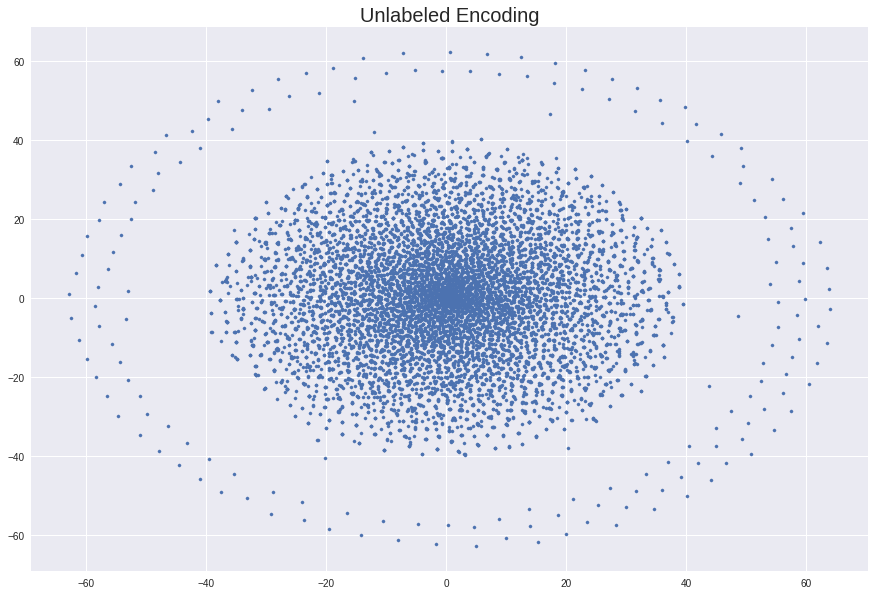

In [71]:
plot_tsne_df(tsne_df)

In [0]:
filename = 'data/acid_properties.csv'
props = pd.read_csv(filename)

In [0]:
######################

In [0]:
def acid_dict(some_c, props):
    prop_by_letter = [props[props.acid == let].iloc[:, 1:] for let in some_c]   
    df_concat = pd.concat(prop_by_letter)
    res = df_concat.mean()
    dres = dict(res)
    dres['acid'] = some_c
    return dres

In [75]:
save_path = 'data/all_acid_dicts.pickle'
producer = lambda: [acid_dict(some_c, props) for some_c in tsne_df.codone]
all_acid_dicts = read_or_create(save_path, producer)

reading data/all_acid_dicts.pickle


In [76]:
all_acid_df = pd.DataFrame(all_acid_dicts)
all_acid_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume
0,MAF,2.166667,116.482633,18.666667,147.133333
1,SAE,-0.833333,95.756400,15.333333,105.333333
2,DVL,1.500000,109.125367,19.000000,139.266667
3,KEY,-2.900000,140.153200,22.333333,166.866667
4,DRR,-4.166667,142.486267,22.666667,152.633333


In [77]:
final_df = all_acid_df.join(tsne_df.set_index('codone'), on='acid')
final_df.head()

,acid,hydrophobicity,mass,number_of_atoms,volume,x0,x1
0,MAF,2.166667,116.482633,18.666667,147.133333,-10.603513,13.747487
1,SAE,-0.833333,95.756400,15.333333,105.333333,-4.858836,1.356179
2,DVL,1.500000,109.125367,19.000000,139.266667,-5.548843,-3.960923
3,KEY,-2.900000,140.153200,22.333333,166.866667,4.845143,-3.698620
4,DRR,-4.166667,142.486267,22.666667,152.633333,17.677906,-6.304618


In [0]:
def plot_embedding_properties(final_df):
    plt.figure(figsize=(25, 20))
    for i, p in enumerate(['hydrophobicity', 'mass', 'number_of_atoms', 'volume']):
        plt.subplot(2,2,i+1)
        plt.title(p, fontsize=25)
        plt.scatter(final_df.x0, final_df.x1, c=final_df[p], s=10)
    plt.show()

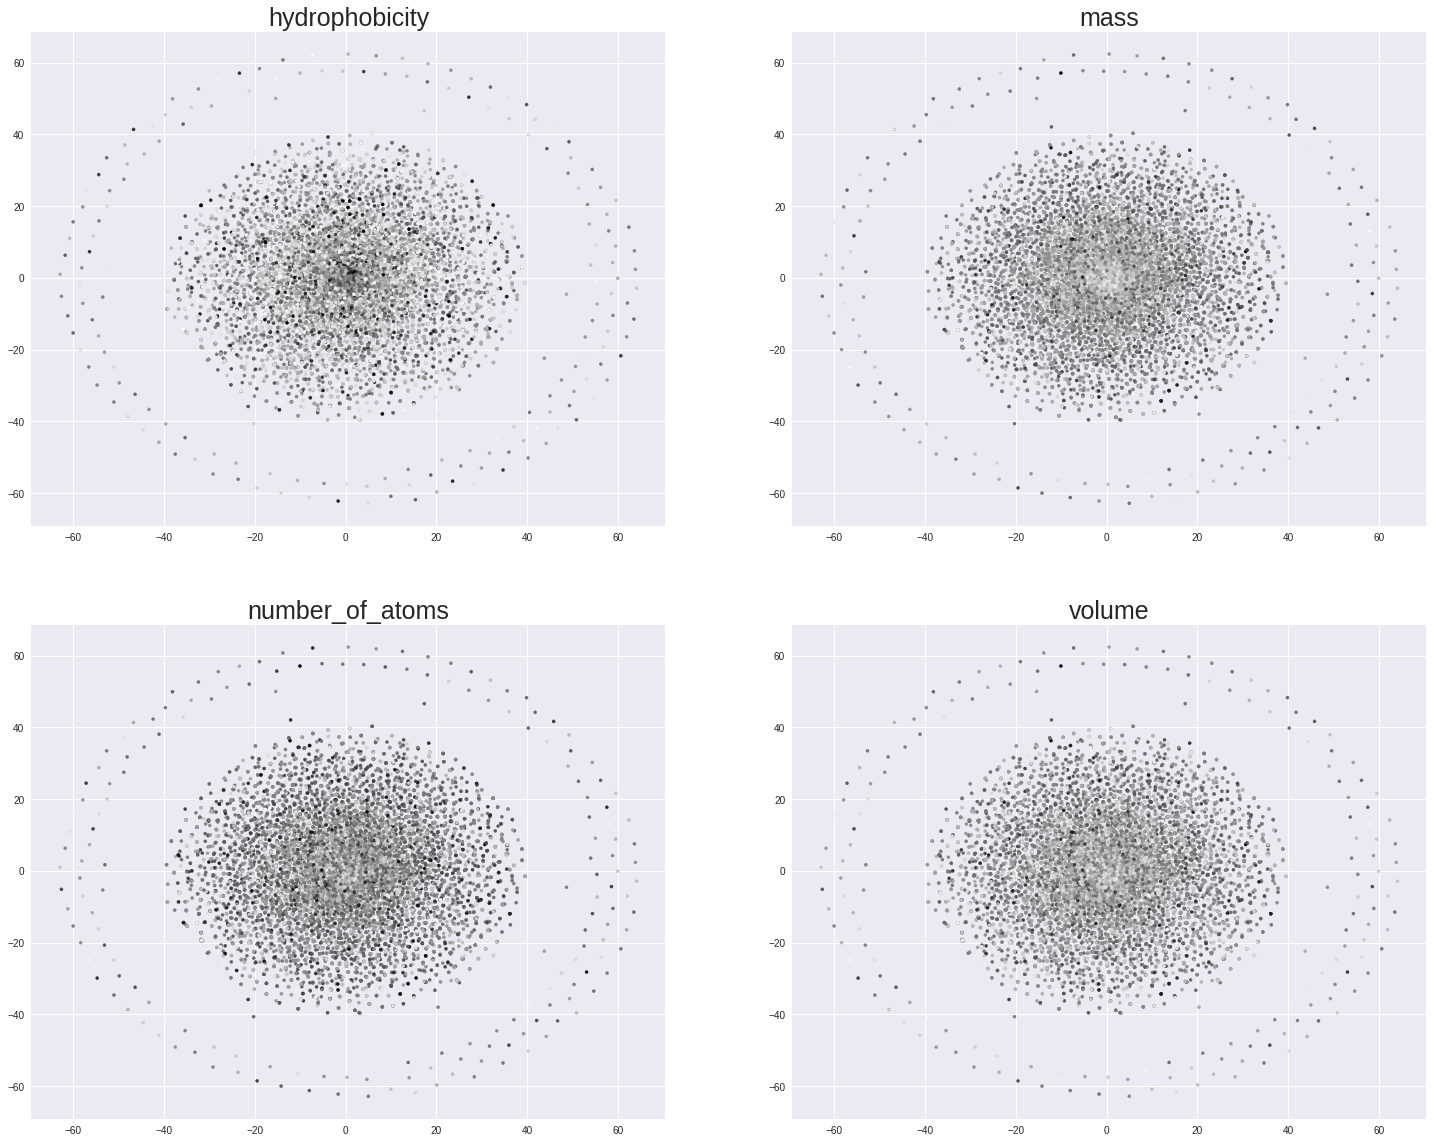

In [79]:
plot_embedding_properties(final_df)

# End of homework
================================

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_embedding_properties(final_df)

In [0]:
######################

In [0]:
# OLD, LEFT FOR COMPARISON
# filename = 'data/nice_embed_tsne.csv'
# gensim_tsne_df = pd.read_csv(filename, index_col=0)
# gensim_tsne_df.columns = ['x0', 'x1', 'codone']

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_tsne_df(gensim_tsne_df)

In [0]:
# OLD, LEFT FOR COMPARISON
# final_df_nice = all_acid_df.join(gensim_tsne_df.set_index('codone'), on='acid')

In [0]:
# OLD, LEFT FOR COMPARISON
# plot_embedding_properties(final_df_nice)

## Homework

* Implement in Pytorch and fine-tune this SkipGramModel to archive better embedding for amino acids codones. 
* Visualize your space in the similar style as on the bottom example. 
* Visualize 3D T-SNE in TensorboardX

Article with the original research can be found here http://journals.plos.org/plosone/article/file?id=10.1371/journal.pone.0141287&type=printable

Bonus task(no credit): visualize your embedding space in similar manner as minst example: https://www.tensorflow.org/versions/r0.12/how_tos/embedding_viz/

In [0]:
soft deadline: 14.10.2018 at 23.59

hard deadline: 17.01.2018 at 23.59